In [1]:
import matplotlib.pyplot as plt
import torch
import cv2

In [2]:
sys.path.append('poseEstimation')
from demo import *

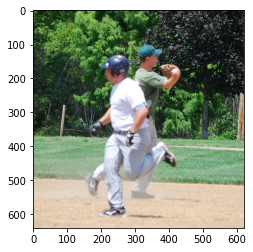

In [3]:
imagePath = "test_data/000000000872.jpg"
frame_provider = ImageReader(imagePath)
image = cv2.imread(imagePath)
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

In [79]:
def run_detection(net, img, height_size, cpu, track, smooth):
    stride = 8
    upsample_ratio = 4
    num_keypoints = Pose.num_kpts
    previous_poses = []
    delay = 1
    orig_img = img.copy()
    heatmaps, pafs, scale, pad = infer_fast(net, img, height_size, stride, upsample_ratio, cpu)

    total_keypoints_num = 0
    all_keypoints_by_type = []
    for kpt_idx in range(num_keypoints):  # 19th for bg
        total_keypoints_num += extract_keypoints(heatmaps[:, :, kpt_idx], all_keypoints_by_type, total_keypoints_num)

    pose_entries, all_keypoints = group_keypoints(all_keypoints_by_type, pafs)
    for kpt_id in range(all_keypoints.shape[0]):
        all_keypoints[kpt_id, 0] = (all_keypoints[kpt_id, 0] * stride / upsample_ratio - pad[1]) / scale
        all_keypoints[kpt_id, 1] = (all_keypoints[kpt_id, 1] * stride / upsample_ratio - pad[0]) / scale
    current_poses = []
    for n in range(len(pose_entries)):
        if len(pose_entries[n]) == 0:
            continue
        pose_keypoints = np.ones((num_keypoints, 2), dtype=np.int32) * -1
        for kpt_id in range(num_keypoints):
            if pose_entries[n][kpt_id] != -1.0:  # keypoint was found
                pose_keypoints[kpt_id, 0] = int(all_keypoints[int(pose_entries[n][kpt_id]), 0])
                pose_keypoints[kpt_id, 1] = int(all_keypoints[int(pose_entries[n][kpt_id]), 1])
        pose = Pose(pose_keypoints, pose_entries[n][18])
        current_poses.append(pose)

    if track:
        track_poses(previous_poses, current_poses, smooth=smooth)
        previous_poses = current_poses
    for pose in current_poses:
        pose.draw(img)
    img = cv2.addWeighted(orig_img, 0.6, img, 0.4, 0)
    # for i, pose in enumerate(current_poses):
        # cv2.rectangle(img, (pose.bbox[0], pose.bbox[1]),
        #                 (pose.bbox[0] + pose.bbox[2], pose.bbox[1] + pose.bbox[3]), (0, 255, 0))
        # if track:
            # cv2.putText(img, 'id: {}'.format(pose.id), (pose.bbox[0], pose.bbox[1] - 16),
                        # cv2.FONT_HERSHEY_COMPLEX, 0.5, (0, 0, 255))
    # plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    return current_poses

In [75]:
net = PoseEstimationWithMobileNet()
checkpoint = torch.load("weights/checkpoint_iter_370000.pth", map_location='cpu')
load_state(net, checkpoint)
cpu = True
track = 0
height_size = 256
smooth = 1
net = net.eval()
if not cpu:
    net = net.cuda()

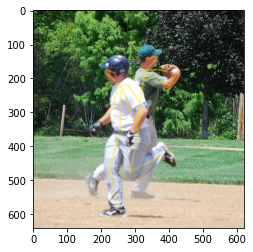

In [38]:
image = cv2.imread(imagePath)
current_poses = runDemo(net, image, height_size, cpu, track, smooth)

In [44]:
import json
import os

In [35]:
# data = {}
# data["images"] = []
# height, width, channels = image.shape
# data["images"].append({
#     "id": 1,
#     "width": width,
#     "height": height,
#     "file_name": imagePath
# })
# with open("data.json", "w") as json_file:
#     json.dump(data, json_file, indent=4)

In [56]:
old_kpt_names = ['nose', 'neck','right_shoulder', 'right_elbow', 'right_wrist', 'left_shoulder', 'left_elbow', 'left_wrist','right_hip', 'right_knee', 'right_ankle', 'left_hip', 'left_knee', 'left_ankle','right_eye', 'left_eye','right_ear', 'left_ear']
new_kpt_names = ["nose","left_eye","right_eye","left_ear","right_ear","left_shoulder","right_shoulder","left_elbow","right_elbow","left_wrist","right_wrist","left_hip","right_hip","left_knee","right_knee","left_ankle","right_ankle"]
skeleton_indexes = [[16,14],[14,12],[17,15],[15,13],[12,13],[6,12],[7,13],[6,7],[6,8],[7,9],[8,10],[9,11],[2,3],[1,2],[1,3],[2,4],[3,5],[4,6],[5,7]]
# old_keypoints = current_poses[0].keypoints.tolist()
# print(old_keypoints)
# new_keypoints = []
# num_keypoints = 0
# for keypoint_name in new_kpt_names:
#     keypoint = old_keypoints[old_kpt_names.index(keypoint_name)]
#     if ((keypoint[0] < 0) & (keypoint[1] < 0)):
#         new_keypoints += [0,0]
#     else:
#         new_keypoints += keypoint
#         num_keypoints += 1
# print(new_keypoints)
# print(num_keypoints)

In [37]:
# data = {}
# with open("data.json", "r") as json_file:
#     data = json.load(json_file)
# data["annotations"] = []
# data["annotations"].append({
#         "keypoints": new_keypoints,
#         "image_id": 1,
#         "id": 1,
#         "category_id": 1,
#         "num_keypoints": num_keypoints
#     })
# with open("data.json", "w") as json_file:
#     json.dump(data, json_file, indent=4)

In [45]:
def walk_through_files(path, file_extension=('.jpg', '.jpeg')):
   for (dirpath, dirnames, filenames) in os.walk(path):
      for filename in filenames:
         if filename.lower().endswith(file_extension):
            yield filename

In [46]:
def convert_keypoints(old_keypoints):
    new_keypoints = []
    num_keypoints = 0
    for keypoint_name in new_kpt_names:
        keypoint = old_keypoints[old_kpt_names.index(keypoint_name)]
        if ((keypoint[0] < 0) & (keypoint[1] < 0)):
            new_keypoints += [0,0]
        else:
            new_keypoints += keypoint
            num_keypoints += 1
    return new_keypoints

In [81]:
def find_poses(path, ouput_json_path):
    data = {}
    data["images"] = []
    data["annotations"] = []
    data["categories"] = []
    images = [os.path.join(path, fname) for fname in walk_through_files(path)]
    for index, fname in enumerate(walk_through_files(path)):
        imagePath = os.path.join(path, fname)
        print(imagePath)
        image = cv2.imread(imagePath)
        # plt.figure()
        # plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
        current_poses = runDemo(net, image, height_size, cpu, track, smooth)
        height, width, channels = image.shape
        data["images"].append({
            "id": index,
            "width": width,
            "height": height,
            "file_name": imagePath
        })
        for pose in current_poses:
            converted_keypoints = convert_keypoints(pose.keypoints.tolist())
            data["annotations"].append({
                "keypoints": converted_keypoints,
                "image_id": index,
                "id": index,
                "category_id": 1,
                "num_keypoints": num_keypoints
            })
    data["categories"].append({
        "supercategory": "person",
        "id": 1,
        "name": "person",
        "keypoints": new_kpt_names,
        "skeleton": skeleton_indexes
    })
    if os.path.isfile(ouput_json_path):
            os.remove(ouput_json_path)
    with open(ouput_json_path, 'w') as outfile:
            json.dump(data, outfile, indent=4)

test_data/biograd-B_00103_left.jpg
test_data/000000000872.jpg
test_data/biograd-B_00076_left.jpg
test_data/biograd-B_00059_left.jpg
test_data/biograd-B_00051_left.jpg


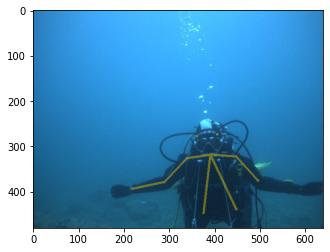

In [82]:
find_poses("test_data/", "data.json")